# 1. Package

In [4]:
import glob, cv2, os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import json
from PIL import Image
from PIL import ImageFile
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as albu
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import copy

from tqdm import tqdm

# # retina
import utils
import torchvision
from engine import train_one_epoch, evaluate
float_formatter = "{:.2f}".format

# Data input

In [7]:
'''fixed train-valid data'''

# 300
train_images = glob.glob('./images/train/*.png')
train_masks = glob.glob('./masks/train/*.png')

# valid_images = glob.glob('./final project/valid/image/*.png')
# valid_masks = glob.glob('./final project/valid/mask/*.png')


train_images.sort()
train_masks.sort()

# valid_images.sort()
# valid_labels.sort()

In [8]:
len(train_images), len(train_masks)
# len(valid_images), len(valid_masks)
# train_images[0]

(300, 300)

# 2. Unet Model 

In [9]:
class conv3x3_bn_relu(nn.Module):
    def __init__(self, in_planes, kernels, stride, padding=1):
        super().__init__()

        self.sequence=nn.Sequential(
            nn.Conv2d(in_planes, kernels, kernel_size=3, stride=stride,
                      padding=padding),
            nn.BatchNorm2d(num_features=kernels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.sequence(x)

In [10]:
class down(nn.Module): #max pool
    def __init__(self, in_planes, kernels, stride, padding=1,
          pooling=True):
        super().__init__()
        self.conv=nn.Sequential(
            # 3x3 convolution + BN(batch normalization) + relu
            conv3x3_bn_relu(in_planes, kernels, stride, padding),
            conv3x3_bn_relu(kernels, kernels, stride, padding),
        )
        self.max_pooling = nn.MaxPool2d(2) if pooling else nn.Identity()

    def forward(self, x):
        return self.conv(self.max_pooling(x))

In [11]:
class up(nn.Module):
    def __init__(self, in_planes, kernels, stride=1, padding=1,
          bilinear=True):
        super().__init__()
        if bilinear:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                self.conv = nn.Sequential(conv3x3_bn_relu(in_planes + in_planes // 2, kernels, stride, padding),
          conv3x3_bn_relu(kernels, kernels, stride, padding),
      )
        else:
                self.up = nn.ConvTranspose2d(in_planes, in_planes//2, kernels_size=2, stride=stride)
                self.conv = nn.Sequential(conv3x3_bn_relu(in_planes, kernels, stride, padding), conv3x3_bn_relu(kernels, kernels, stride, padding),
      )

    def forward(self, x1, x2):
        x2 = self.up(x2)
        #print(x2.shape)
        return self.conv(torch.cat([x1, x2], dim=1))

In [12]:
class UNet(nn.Module): # 1, 3, 1024, 1024
    def __init__(self, n_channel=1, n_class=1, bilinear=True):
        super().__init__()
        self.down1 = down(n_channel, 12, 1, pooling=False)
        self.down2 = down(12, 24, 1)
        self.down3 = down(24, 48, 1)
        self.down4 = down(48, 96, 1)
        self.down5 = down(96, 192, 1)
        self.down6 = down(192, 384, 1) # add a new layer
        self.up1 = up(192*2, 192, 1, bilinear=bilinear)
        self.up2 = up(96*2, 96, 1, bilinear=bilinear)
        self.up3 = up(48*2, 48, 1, bilinear=bilinear)
        self.up4 = up(24*2, 24, 1, bilinear=bilinear)
        self.up5 = up(12*2, 12, 1, bilinear=bilinear)
        self.out = nn.Conv2d(12, n_class, 3, 1, padding=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5) #add a new layer
        x = self.up1(x5, x6) + x5
        x = self.up2(x4, x) + x4
        x = self.up3(x3, x) + x3
        x = self.up4(x2, x) + x2
        x = self.up5(x1, x) + x1
        logit = self.out(x)
        return logit

In [13]:
unet = UNet()

In [14]:
output = unet(torch.randn(size = (9,1,1024,1024))) # (b,c,h,w) = (batch, channel, height, width)
print(output.shape)

torch.Size([9, 1, 1024, 1024])


# 3. Augmentation

In [15]:
def get_simple_training_augmentation():
    aug = [
        albu.GlassBlur(p=0.2),
        albu.GaussNoise(var_limit=(1,3),p=0.3), 
        albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, always_apply=False, p=0.2),
        albu.HorizontalFlip(p=0.5),  
        albu.Resize(height=1024, width=1024, p=1),
#         albu.PadIfNeeded(1024, 1024, always_apply=True, border_mode=cv2.BORDER_CONSTANT),
        ToTensorV2(transpose_mask=True)
    ]
    return albu.Compose(aug)


def get_validation_augmentation():
    aug = [
         albu.Resize(height=1024, width=1024, p=1),
#          albu.PadIfNeeded(1216, 512, always_apply=True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask=True)
    ]
    return albu.Compose(aug)

In [16]:
class AugmentedImageDataset(Dataset):
    def __init__(self, images, labels, augmentation=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.augmentation = augmentation
        
    def __getitem__(self, index):

        # Get path
        img = self.images[index]
        label = self.labels[index]
#         num = int(label[-8:-4])
#         print(num)
        
        # Read image
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

        # Augmentation
        if(self.augmentation):
            sampled = self.augmentation(image=img, mask=label)
            img = sampled['image']
            label = sampled['mask']
        
        # 增加channel這個維度
#         img = img[:,:,np.newaxis]
#         img = img.permute(1, 2, 0)
        label = label[np.newaxis,:,:]
        
        return torch.div(img, 255), torch.div(label, 255)

    def __len__(self):
        return len(self.images)

# 5. Training Setting

In [17]:
class Dice(nn.Module):
    def __init__(self, eps=1e-7, threshold=0.5):
        super().__init__()
        self.eps = eps
        self.threshold = threshold
        self.activation = torch.sigmoid

    @property
    def __name__(self):
        return 'Dice'

    def _threshold(self, x):
        return (x > self.threshold).type(x.dtype)

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        y_pr = self._threshold(y_pr)

        tp = torch.sum(y_gt * y_pr)
        fp = torch.sum(y_pr) - tp
        fn = torch.sum(y_gt) - tp

        score = torch.div((2 * tp + self.eps), (2 * tp + fn + fp + self.eps))
        return score

class AverageValueMeter(object):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 1:
            self.mean = 0.0 + self.sum
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0

        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.mean
        self.mean_old = np.nan
        self.m_s = 0.0
        self.std = np.nan

def to_string(logs):
    str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
    s = ', '.join(str_logs)
    return s

In [25]:
epochs = 30
lr = 5e-5
weight_decay = 1e-5
kfold = 4
save_path = './final project/weight'

bce_loss = nn.BCEWithLogitsLoss()
metric = Dice()
optimizer = torch.optim.Adam

device = 'cuda' if torch.cuda.is_available else 'cpu'

batch_size = 9
num_workers = 0
shuffle = True
drop_last = True
pin_memory = True

# 6. Training & Validaion

In [ ]:
len(train_images)

In [ ]:
def get_train_valid_data(fold):
    train_img_f1 = train_images[0:300:4]
    train_img_f2 = train_images[1:300:4]
    train_img_f3 = train_images[2:300:4]
    train_img_f4 = train_images[3:300:4]
    train_msk_f1 = train_masks[0:300:4]    
    train_msk_f2 = train_masks[1:300:4]
    train_msk_f3 = train_masks[2:300:4]
    train_msk_f4 = train_masks[3:300:4]
    
    if fold%4 == 0:
        train_image = train_img_f2 + train_img_f3 + train_img_f4
        train_label = train_msk_f2 + train_msk_f3 + train_msk_f4
        
        valid_image = train_img_f1
        valid_label = train_msk_f1
        
    elif fold%4 == 1:
        train_image = train_img_f1 + train_img_f3 + train_img_f4
        train_label = train_msk_f1 + train_msk_f3 + train_msk_f4
        
        valid_image = train_img_f2
        valid_label = train_msk_f2
        
    elif fold%4 == 2:
        train_image = train_img_f1 + train_img_f2 + train_img_f4
        train_label = train_msk_f1 + train_msk_f2 + train_msk_f4
        
        valid_image = train_img_f3
        valid_label = train_msk_f3
        
    else:
        train_image = train_img_f1 + train_img_f3 + train_img_f2
        train_label = train_msk_f1 + train_msk_f3 + train_msk_f2
        
        valid_image = train_img_f4
        valid_label = train_msk_f4

    print("len(train_img_f1): ", len(train_img_f1))    
    print("len(train_img_f2): ", len(train_img_f2))    
    print("len(train_img_f3): ", len(train_img_f3))    
    print("len(train_image): ", len(train_image))

#     print("train_label.shape: ", train_label.shape)

    train_image.sort()
    train_label.sort()
    valid_image.sort()
    valid_label.sort()         

    print(type(train_image))
    return (train_image, train_label), (valid_image, valid_label)             
  

In [ ]:
(train_image, train_label), (valid_image, valid_label) = get_train_valid_data(3)
train_dataset = AugmentedImageDataset(train_image, train_label, get_simple_training_augmentation())
# valid_dataset = AugmentedImageDataset(valid_images, valid_labels, get_validation_augmentation())
train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)
# valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)
# myDataloader = DataLoader(dataset=myDataset, batch_size=10, shuffle=False, num_workers=0, drop_last=True)
train_loader_iter = iter(train_loader)

In [ ]:
len(train_loader)

In [ ]:
len(train_images)

In [ ]:
k_fold_best = [0] * kfold

for fold in range(kfold):

    (train_image, train_label), (valid_image, valid_label) = get_train_valid_data(fold)

    train_dataset = AugmentedImageDataset(train_image, train_label, get_simple_training_augmentation())
    valid_dataset = AugmentedImageDataset(valid_image, valid_label, get_validation_augmentation())
    train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)

    seg_model = UNet()
    opt = optimizer(seg_model.parameters(), lr=lr, weight_decay=weight_decay)

    seg_model.to(device)
    metric.to(device)

    model_name = os.path.join(save_path, str(fold+1), 'Unet.h5')
    max_score = 0

    for epoch in range(epochs):
        print('Epoch: %d' %(epoch+1))

        #training phase
        seg_model.train() 

        train_logs = {}
        loss_meter = AverageValueMeter()
        metric_meter = AverageValueMeter()
        with tqdm(train_loader, desc='Train', file=sys.stdout) as iterator:
            for imgs, gts in iterator:

                imgs = imgs.to(device, dtype = torch.float) #input記得要跟model在同一個device上
                gts = gts.to(device, dtype = torch.float)
                preds = seg_model(imgs)
                preds = torch.sigmoid(preds)
                loss = bce_loss(preds, gts)

                # 計算gradient
                loss.backward()
                #根據gradient和lr等等更新網路權重
                opt.step()
                #記得清零，否則會保留上一個batch的grad
                opt.zero_grad()

                loss_val = loss.cpu().detach().numpy()
                loss_meter.add(loss_val)
                train_logs.update({'CrossEntropy': loss_meter.mean})

                metric_val = metric(preds, gts).cpu().detach().numpy()
                metric_meter.add(metric_val)
                train_logs.update({metric.__name__: metric_meter.mean})

                iterator.set_postfix_str(to_string(train_logs))

        #validation phase
        seg_model.eval()

        val_logs = {}
        loss_meter = AverageValueMeter()
        metric_meter = AverageValueMeter()
        with tqdm(valid_loader, desc='Valid', file=sys.stdout) as iterator:
            for imgs, gts in iterator:
                with torch.no_grad(): #!!!!!不算gradient!!!!!!

                    imgs = imgs.to(device, dtype=torch.float)
                    gts = gts.to(device, dtype=torch.float)
                    preds = seg_model(imgs)
                    loss = bce_loss(preds, gts)

                loss_val = loss.cpu().detach().numpy()
                loss_meter.add(loss_val)
                val_logs.update({'CrossEntropy': loss_meter.mean})

                metric_val = metric(preds, gts).cpu().detach().numpy()
                metric_meter.add(metric_val)
                val_logs.update({metric.__name__: metric_meter.mean})

                iterator.set_postfix_str(to_string(val_logs))

        if max_score < val_logs['Dice']:
            max_score = val_logs['Dice']
            k_fold_best[fold] = val_logs['Dice']

            torch.save(seg_model.state_dict(), model_name)
            print('Model Save !!!!')

print('\n')
print('K-Fold average Dice : %0.4f' %(sum(k_fold_best) / len(k_fold_best)))


# 6. Visualizing Activations

In [28]:
test_images = glob.glob('./class_data/Val/powder_uncover/image/*.png')
test_masks = glob.glob('./class_data/Val/powder_uncover/mask/*.png')
test_images.sort()
test_masks.sort()

test_dataset = AugmentedImageDataset(test_images, test_masks, get_validation_augmentation())

In [29]:
seg_model = UNet(1)
seg_model.eval()
seg_model.load_state_dict(torch.load('Unet.h5', map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
len(test_dataset)

50

In [35]:
with torch.no_grad():
    img, label = test_dataset[0]
    pred = seg_model(img.unsqueeze(0))
    pred = torch.sigmoid(pred).detach().numpy()
#     print(pred)
#     pred = np.where(pred > 0.495, 1, 0)
    pred = np.where(pred > 0.51, 1.0, 0.0)
    pred = torch.from_numpy(pred)
    pred = pred.squeeze(0)
#     print(pred.shape)
#     print(label.shape)


    val_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    loss = bce_loss(pred, label)
    metric_val = metric(pred, label).cpu().detach().numpy()
    print(metric_val)
    metric_meter.add(metric_val)
    val_logs.update({metric.__name__: metric_meter.mean})
    print("Dice Coefficient: ", val_logs[metric.__name__])

0.07301529380654266
Dice Coefficient:  0.07301529380654266


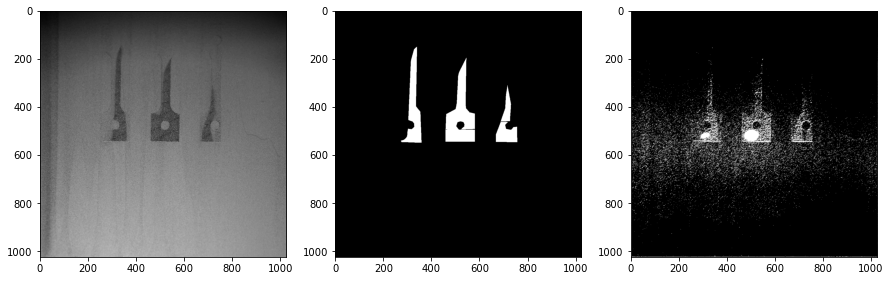

In [32]:
plt.figure(figsize=(15, 7))

# Plot input img
plt.subplot(1,3,1)
plt.imshow(img.squeeze(0), cmap = 'gray')

# Plot label
plt.subplot(1,3,2)
plt.imshow(label.squeeze(0), cmap = 'gray')

# Plot pred
plt.subplot(1,3,3)
plt.imshow(pred.squeeze(0), cmap = 'gray')